In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem



import utils
import gaussian_cal
import pandas as pd
import subprocess
import os
import time
from rdkit.Chem import PandasTools
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from rdkit.Chem import Draw

import matplotlib.pyplot as plt

In [69]:
base = 'C=CCN1C(=O)N(C(=O)N(C1=O)CC=C)CC=C'

**FFKM**

In [178]:
def FFKM_builder(m,n,c,connection_direction):
    FFKM = n * 'C(F)(F)C(F)(F)' +  m * 'C(F)(F)C(OC(F)(F)(F))(F)'
    if connection_direction == 'L':
        connection_point = 0
        FFKM = c*'C'+ FFKM + 'F'
    elif connection_direction == 'R':
        FFKM = 'F' + FFKM + 'C' * c
        if c == 0:
            connection_point = 6*n + 10 * (m-1) +3 + 1
        else:
            connection_point = 6 * n + 10 * m + c
    return FFKM, connection_point


def crosslink_reaction(base,FFKM,connection_point):
    mol = Chem.MolFromSmiles(base)
    patt = Chem.MolFromSmarts('[C;!R]C=[C;!R]')
    repl = Chem.MolFromSmiles(FFKM)
    rms = AllChem.ReplaceSubstructs(mol, patt, repl, replaceAll=True, replacementConnectionPoint=connection_point)
    s1 = Chem.MolToSmiles(rms[0])
    # s1=s1.replace('O=C1C', 'O=C1N',1)
    return s1

def multiplot(smiles_list, cids, name):
    # 创建一个10x10的子图布局
    num_rows = len(smiles_list) // 8 + 1
    num_cols = 8
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))

    # 遍历SMILES表达式并在子图中显示
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            ax = axs[i // num_cols, i % num_cols]
            img = Draw.MolToImage(mol, size=(450, 450))
            ax.imshow(img)
            ax.axis('off')  # 关闭坐标轴
            ax.set_title(f"{cids[i]}", fontsize=30)  # 添加子图标题
    # for i in range(20, num_rows * num_cols):
    for i in range(len(smiles_list), num_rows * num_cols):
        axs.flatten()[i].axis('off')
    # 调整子图布局
    plt.tight_layout()
    plt.savefig(name,dpi=300,format='pdf')

In [ ]:
###test
FFKM,connection_point = FFKM_builder(m = m,n = n, c=1,connection_direction="L")
crossed_mol = crosslink_reaction(base,FFKM,connection_point)
Draw.MolToImage(visualize_smiles(crossed_mol),size=(600,600))

In [160]:
name_list = []
smiles_list = []
for direction in ['L','R']:
    for c in range(4):
        for m in [1]:
            for n in [1,2]:
                FFKM,connection_point = FFKM_builder(m = m,n = n, c=c,connection_direction=direction)
                crossed_mol = crosslink_reaction(base,FFKM,connection_point)
                name_list.append(f'taic{direction}M{m}N{n}C{c}')
                smiles_list.append(crossed_mol)

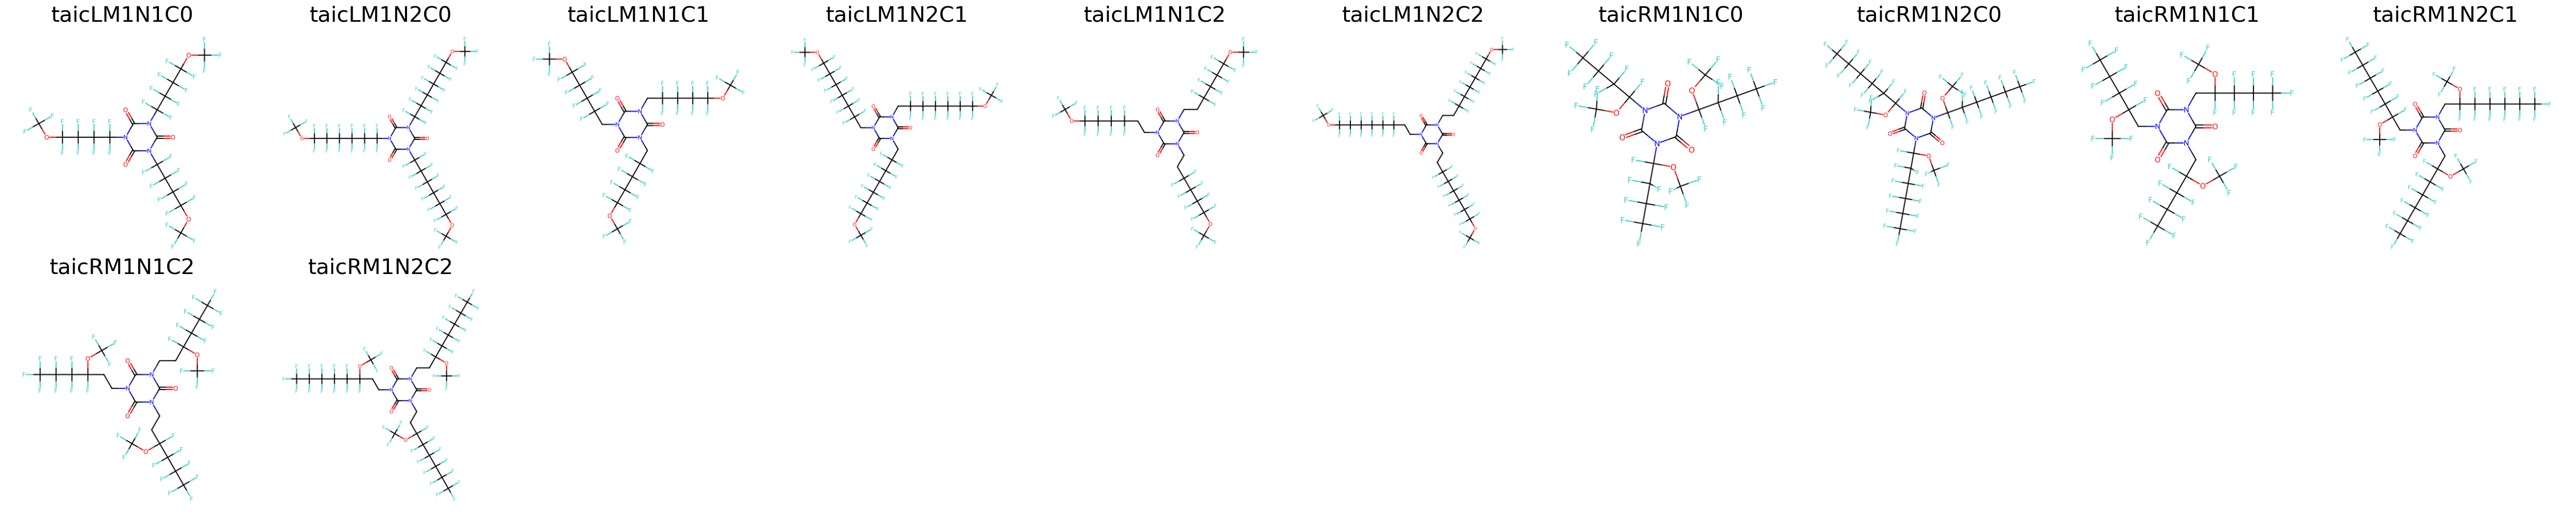

In [161]:
multiplot(smiles_list, name_list, 'FFKM_investigation.pdf')

**计算方法，计算基组**

In [165]:
method = 'CAM-B3LYP'
basis = '6-31G(d,p)'
PCM = 'True'
EPS = 4.9
iteration = 5
debug = False

**根据smiles表达式生成分子的xyz文件**

In [163]:
for i in tqdm(range(len(name_list))):
    for j in range(iteration):
        try:
            utils.smile2xyz(name_list[i]+str(j)+'_0.xyz',smiles_list[i],randomSeed=None)
        except:
            print(name_list[i]+str(j))

 50%|█████     | 6/12 [00:06<00:06,  1.15s/it]

taicLM1N2C23
taicLM1N2C24


100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


In [ ]:
G0 = gaussian_cal.GaussianCal(method=method,basis=basis,charge='neu',wfn=True,debug=debug,PCM=PCM,EPS=EPS)
G1 = gaussian_cal.GaussianCal(method=method,basis=basis,charge='pos',wfn=True,debug=debug,PCM=PCM,EPS=EPS)

for i in range(len(name_list)):
    for j in range(iteration):
        if os.path.exists(f"{name_list[i]}{j}"):
            if debug:
                while utils.i8cpu_running():
                    time.sleep(60)
            G0.Run(f"{name_list[i]}{j}_0.xyz")
            if debug:
                while utils.i8cpu_running():
                    time.sleep(60)
            G1.Run(f"{name_list[i]}{j}_0.xyz")

**Result Analysis**

In [171]:
def data_to_csv(prop,prop_calculation):
    names = locals()
    names[prop],names[f'{prop}_name'] = [],[]
    for _ in tqdm(name_list):
        for i in range (200):
            if os.path.exists(f"{_}{i}"):
                names[prop].append(float("{:.3f}".format((prop_calculation((f"{_}{i}"))))))
                names[f'{prop}_name'].append(f"{_}{i}")

    column_name = [f'Name_{prop}(eV)', f'{method}_{basis}_PCM' if PCM else f'{method}_{basis}_Gas']
    table = pd.DataFrame({column_name[0]: names[f'{prop}_name'], column_name[1]: names[prop]})
    table.to_csv(f'{method}_{basis}_PCM_{prop}' if PCM else f'{method}_{basis}_Gas_{prop}', index=False)
    df = table.drop([f'Name_{prop}(eV)'], axis=1)
    try:
        reshaped_data = df[ f'{method}_{basis}_PCM' if PCM else f'{method}_{basis}_Gas'].values.reshape(len(name_list), iteration).T
    except:
        reshaped_data = df[ f'{method}_{basis}_PCM' if PCM else f'{method}_{basis}_Gas'].values.reshape(len(name_list), iteration).T
    new_df = pd.DataFrame(reshaped_data, columns=[f'{name_list[i]}' for i in range(len(name_list))])
    new_df.to_csv(f'{method}_{basis}_PCM_{prop}.csv' if PCM else f'{method}_{basis}_Gas_{prop}.csv', index=False)
    return new_df
def data_wash(df):
    df.replace()
    df.replace(0, np.nan, inplace=True)
    mean_values = df.mean()
    df.fillna(mean_values, inplace=True)
    return df
def data_mean_std(df):
    mean_values = df.mean().round(3)
    std_values = df.std().round(3)
    df.loc['mean'] = mean_values
    df.loc['std'] = std_values
    return df


In [175]:
df_IP = data_to_csv('IP',utils.IP_calculation)
df_IP = data_wash(df_IP)
df_IP

100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


,taicLM1N1C0,taicLM1N2C0,taicLM1N1C1,taicLM1N2C1,taicLM1N1C2,taicLM1N2C2,taicRM1N1C0,taicRM1N2C0,taicRM1N1C1,taicRM1N2C1,taicRM1N1C2,taicRM1N2C2
0,9.689,9.6660,9.102,9.1340,8.734,8.990000,9.512333,9.53775,9.115,9.09200,8.798,8.924333
1,9.698,9.6555,9.123,9.1010,8.751,8.992000,9.485000,9.49700,9.087,9.10775,8.859,9.002000
2,9.694,9.6720,9.119,9.1175,8.740,8.958667,9.530000,9.52800,9.057,9.11000,8.839,8.924333
3,9.670,9.6260,9.134,9.1175,8.751,8.894000,9.522000,9.59500,9.056,9.13500,8.839,8.751000
4,9.739,9.6580,9.117,9.1175,8.779,8.958667,9.512333,9.53100,9.057,9.09400,8.860,9.020000


In [176]:
column_means = df_IP.mean()
df_IP = df_IP.append(column_means, ignore_index=True, sort=False)
df_IP
df_new = df_IP.drop(range(iteration)).reset_index(drop=True)
df_new
df_cleaned = df_new.dropna(axis=1)
df_cleaned = df_cleaned.T
df_cleaned
df_cleaned = df_cleaned.rename(columns={df_cleaned.columns[0]: 'mean'})
# df_cleaned=df_cleaned.sort_values(by='mean', ascending=True)
df_cleaned

/tmp/ipykernel_619033/3073936164.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_IP = df_IP.append(column_means, ignore_index=True, sort=False)


,mean
taicLM1N1C0,9.698000
taicLM1N2C0,9.655500
taicLM1N1C1,9.119000
taicLM1N2C1,9.117500
taicLM1N1C2,8.751000
taicLM1N2C2,8.958667
taicRM1N1C0,9.512333
taicRM1N2C0,9.537750
taicRM1N1C1,9.074400
taicRM1N2C1,9.107750


In [177]:
IP = list(df_cleaned['mean'])
IP = [round(_,3) for _ in IP]
IP

[9.698,
 9.655,
 9.119,
 9.117,
 8.751,
 8.959,
 9.512,
 9.538,
 9.074,
 9.108,
 8.839,
 8.924]

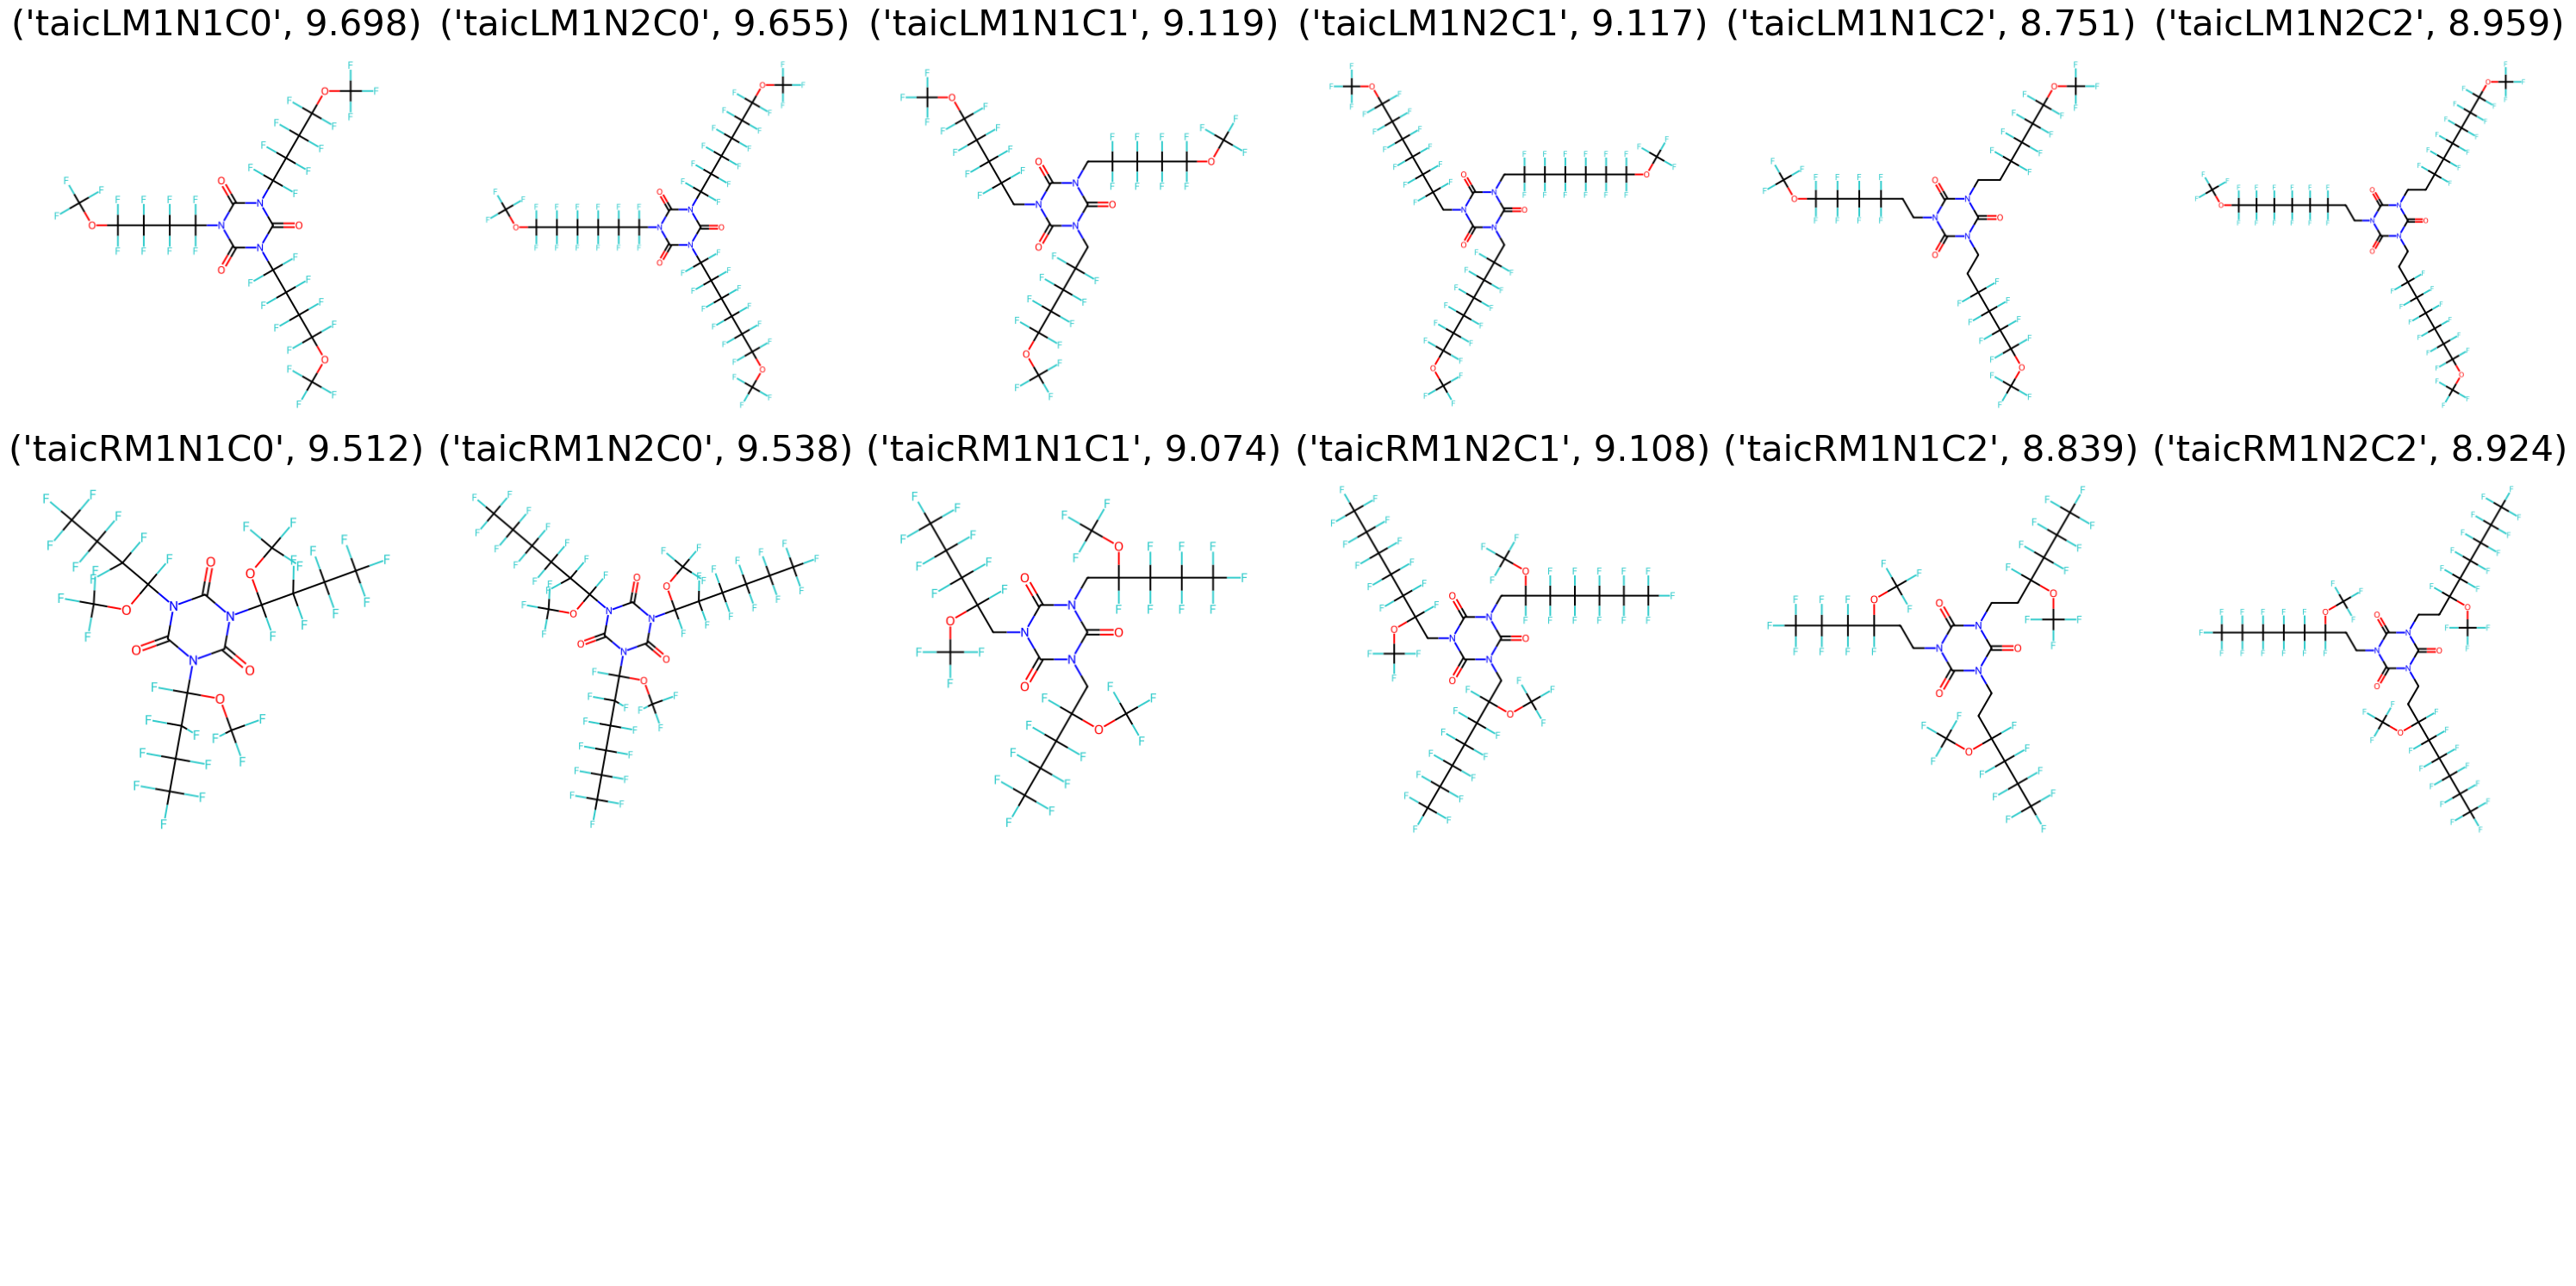

In [180]:
def multiplot(smiles_list, cids, IP, name):
    # 创建一个10x10的子图布局
    num_rows = len(smiles_list) // 6 + 1
    num_cols = 6
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))

    # 遍历SMILES表达式并在子图中显示
    for i, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            ax = axs[i // num_cols, i % num_cols]
            img = Draw.MolToImage(mol, size=(450, 450))
            ax.imshow(img)
            ax.axis('off')  # 关闭坐标轴
            ax.set_title(f"{cids[i],IP[i]}", fontsize=30)  # 添加子图标题
    # for i in range(20, num_rows * num_cols):
    for i in range(len(smiles_list), num_rows * num_cols):
        axs.flatten()[i].axis('off')
    # 调整子图布局
    plt.tight_layout()
    plt.savefig(name,dpi=300,format='pdf')
multiplot(smiles_list, name_list, IP, 'FFKM_investigation_IP.pdf')

In [14]:
HOMO_mean,HOMO_median = corrcoef(df_HOMO)

-0.4128545754436086
-0.4119556824428409
-0.3704614991595833
-0.34933562787025757
-0.45894815123763905
mean -0.40461955003387384
median -0.3989120290485083


In [65]:
plt.rcdefaults()

def prop_charge(x, y, title='None',xlabel = 'None',ylabel = 'None'):
    # 示例形状和标签
    shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
    labels = [f'{name_list[i]}' for i in range(len(x))]
    co = round(np.corrcoef(x, y)[0,1],3)
    # 创建散点图并指定不同的形状和标签
    plt.figure(figsize=(6, 6))
    plt.tick_params(axis='both', direction='in', which='both')
    plt.grid(linestyle='-.')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
    # 添加图例
    if co < 0:
        plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=2, title="CYTOP")
    else:
        plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")

    # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
    # 设置图形标题和坐标轴标签
    plt.title(f"Correlation Coefficient: {co}",fontsize=15,fontweight='bold')
    plt.xlabel(xlabel,fontsize=12,fontweight='bold')
    plt.xticks(fontsize=10)  # X轴刻度字体大小
    plt.yticks(fontsize=10) 
    plt.ylabel(ylabel,fontsize=12,fontweight='bold')
    if max(y) < 1:
        plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(title,dpi=300)
    # 显示图形
    plt.show()

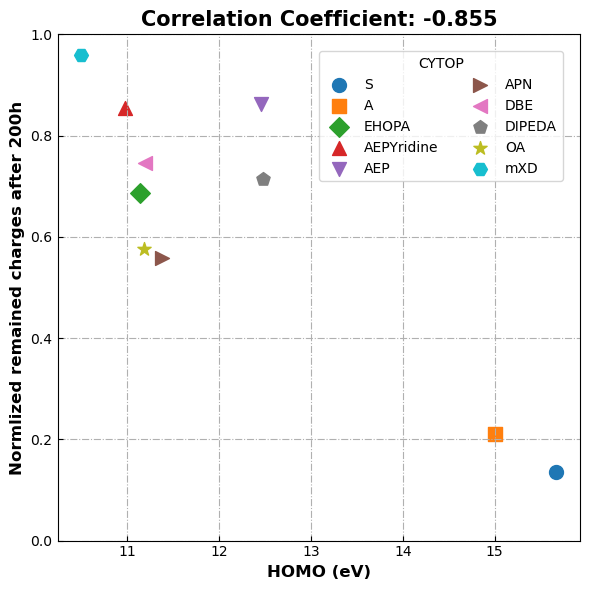

In [86]:
prop_charge(HOMO_mean,
              psp_Mao,
              title='CC_HOMO_psp',
              xlabel = 'HOMO (eV)',
              ylabel = 'Normlized remained charges after 200h' )


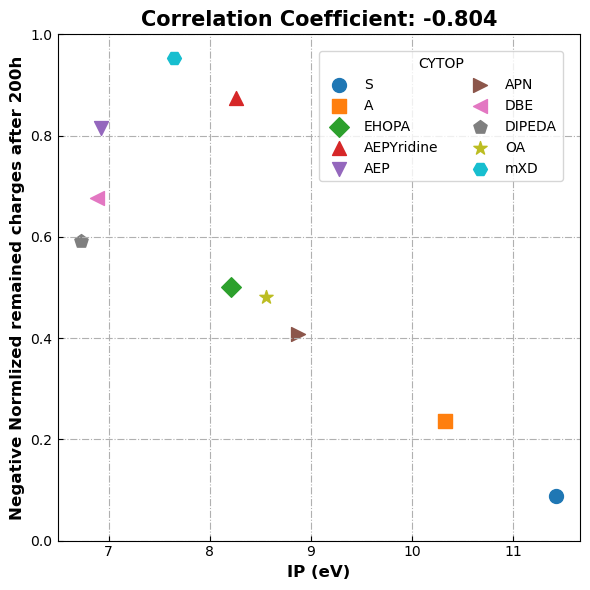

In [101]:
prop_charge(IP_mean,
              nsp_Mao,
              title='CC_IP_nsp',
              xlabel = 'IP (eV)',
              ylabel = 'Negative Normlized remained charges after 200h' )


In [83]:
plt.rcdefaults()

def prop_com(x, y,title='None',xlabel = 'None',ylabel = 'None'):
    # 示例形状和标签
    shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
    labels = [f'{name_list[i]}' for i in range(len(x))]
    co = round(np.corrcoef(x, y)[0,1],3)
    # 创建散点图并指定不同的形状和标签
    plt.figure(figsize=(6, 6))
    plt.tick_params(axis='both', direction='in', which='both')
    plt.plot([min(min(x),min(y)),max(max(x),max(y))],[min(min(x),min(y)),max(max(x),max(y))],linestyle='--',color='black')
    plt.grid(linestyle='-.')
    for i in range(len(x)):
        plt.scatter(x[i], y[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
    # 添加图例
    if co < 0:
        plt.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), ncol=2, title="CYTOP")
    else:
        plt.legend(loc='lower right', bbox_to_anchor=(0.98, 0.02), ncol=2, title="CYTOP")
    # 设置图形标题和坐标轴标签
    plt.title(f"Correlation Coefficient: {co}",fontsize=15,fontweight='bold')
    plt.xlabel(xlabel,fontsize=12,fontweight='bold')
    plt.xticks(fontsize=10)  # X轴刻度字体大小
    plt.yticks(fontsize=10) 
    plt.ylabel(ylabel,fontsize=12,fontweight='bold')
    plt.tight_layout()
    plt.savefig(title,dpi=300)
    # 显示图形
    plt.show()

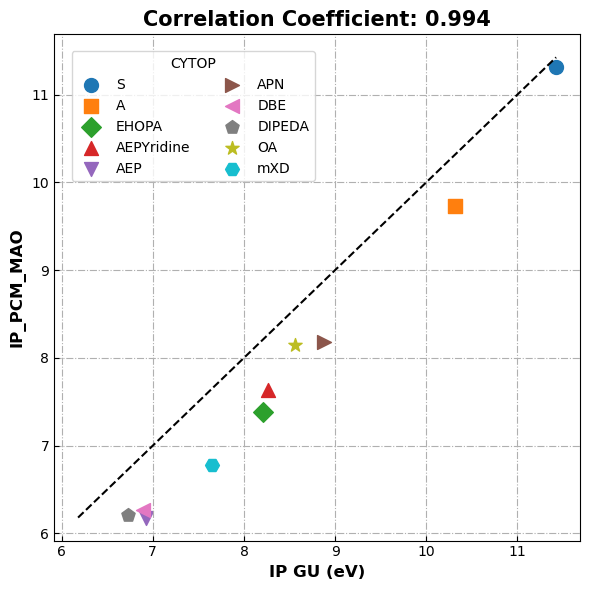

In [72]:
prop_com(IP_mean,
        ip_pcm_Mao,
        title='CC_IP(GU)_IP(MAO)',
        xlabel = 'IP GU (eV)',
        ylabel = 'IP_PCM_MAO(eV)' )


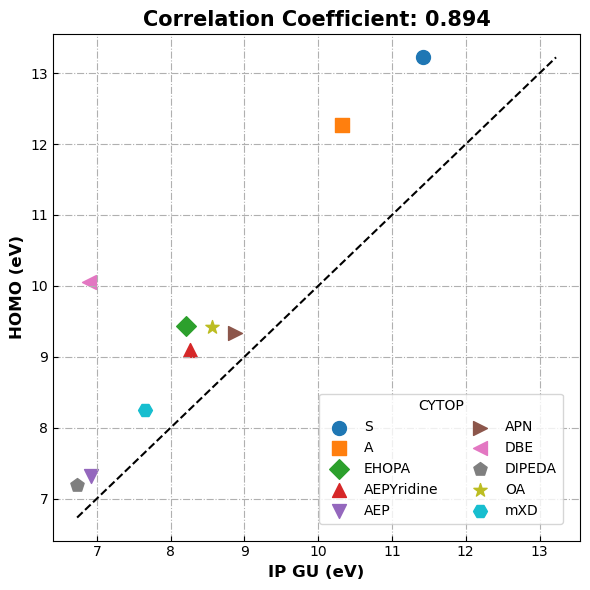

In [100]:
prop_com(IP_mean,
        HOMO_mean,
        title='CC_IP(GU)_HOMO',
        xlabel = 'IP GU (eV)',
        ylabel = 'HOMO (eV)' )


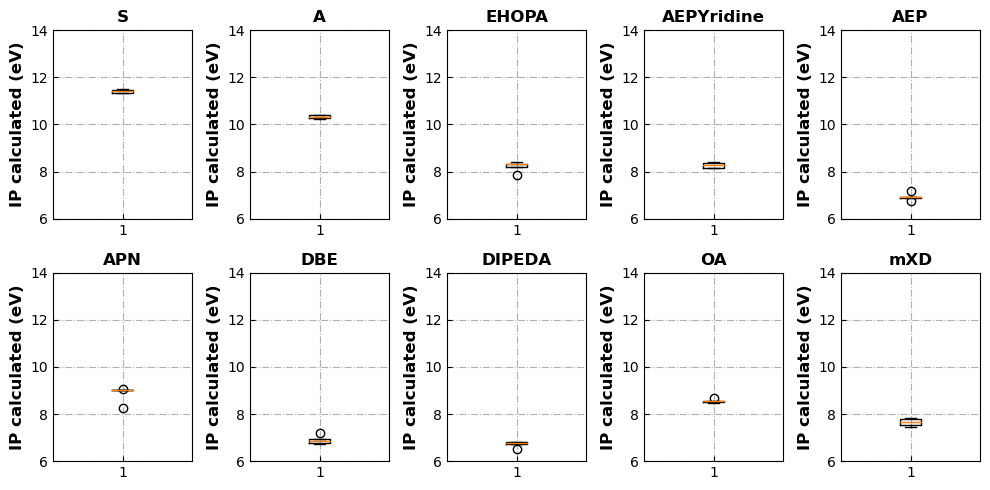

In [28]:

# 示例数据，替换为你的IP值数据
# 统计描述

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.boxplot(df_IP.iloc[:,i], vert=True)  # 绘制箱型图
    ax.set_ylabel('IP calculated (eV)',fontsize=12,fontweight='bold')
    ax.grid(linestyle='-.')
    ax.tick_params(axis='both', direction='in')  # 'both'表示x和y轴都调整
    ax.set_ylim(6,14)
    ax.set_title(f'{name_list[i]}',fontsize=12,fontweight='bold')
plt.tight_layout()
plt.savefig('CYTOP_camb3lyp-631(dp)_IP_rdkit.png', dpi=300)

plt.show()


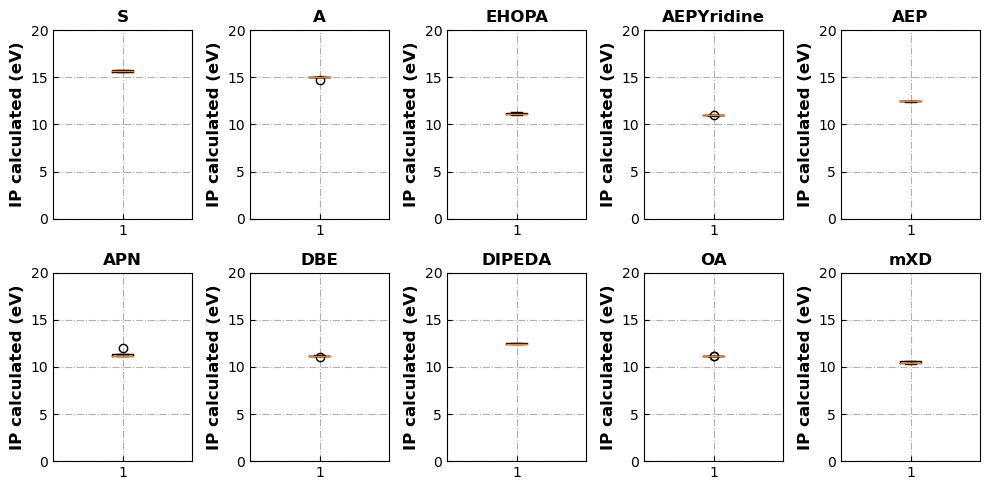

In [89]:
# 示例数据，替换为你的IP值数据
# 统计描述

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.boxplot(df_HOMO.iloc[:,i], vert=True)  # 绘制箱型图
    ax.set_ylabel('IP calculated (eV)',fontsize=12,fontweight='bold')
    ax.grid(linestyle='-.')
    ax.tick_params(axis='both', direction='in')  # 'both'表示x和y轴都调整
    ax.set_ylim(0,20)
    ax.set_title(f'{name_list[i]}',fontsize=12,fontweight='bold')
plt.tight_layout()
# plt.savefig('CYTOP_camb3lyp-631(dp)_IP_rdkit.png', dpi=300)

plt.show()

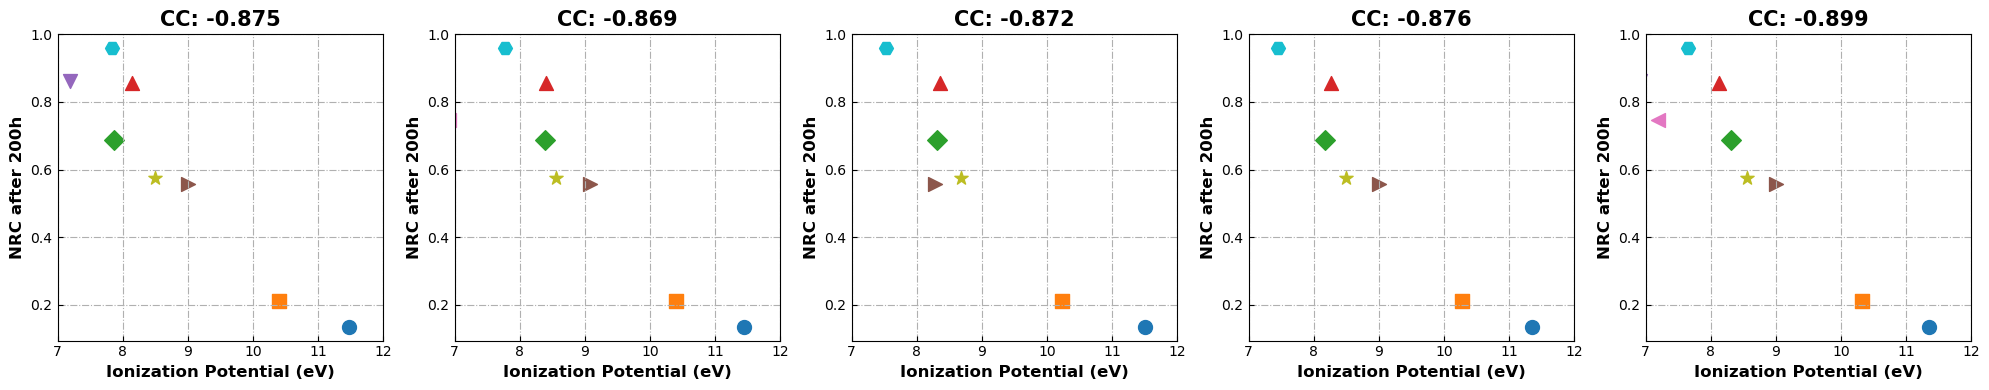

<Figure size 640x480 with 0 Axes>

In [30]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# 示例形状和标签
shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']

for j, ax in enumerate(axes.ravel()):
    if j < len(name_list):
        # 创建散点图并指定不同的形状和标签
        shapes = ['o', 's', 'D', '^', 'v', '>', '<', 'p', '*', 'H']
        labels = [f'{name_list[i]}' for i in range(10)]
        co = round(np.corrcoef(rdkit_df.iloc[j,:], psp)[0,1],3)
        # 创建散点图并指定不同的形状和标签
        ax.tick_params(axis='both', direction='in', which='both')
        ax.grid(linestyle='-.')
        for i in range(10):
            ax.scatter(rdkit_df.iloc[j,:][i], psp[i], marker=shapes[i], label=labels[i], s=100)  # 每个点的形状和标签
        # 添加图例
        # plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
        # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
        # 设置图形标题和坐标轴标签
        ax.set_title(f"CC: {co}",fontsize=15,fontweight='bold')
        ax.set_xlabel("Ionization Potential (eV)",fontsize=12,fontweight='bold')     
        ax.tick_params(axis='both', direction='in', which='both')
        ax.set_xlim(7,12)
        ax.set_ylabel("NRC after 200h",fontsize=12,fontweight='bold')
plt.tight_layout()
# 显示图形
plt.savefig('random.png',dpi=300)
plt.show()

# 调整子图之间的间距
plt.tight_layout()

In [32]:
# T1,T2,T_all = [],[],[]
# time_dict = {}
# for _ in name_list:
#     for i in range(10):
#         if os.path.exists(f"{_}{i}"):
#             t1 = utils.time_calculation(f"{_}{i}/{_}{i}_p1.log")
#             t2 = utils.time_calculation(f"{_}{i}/{_}{i}_0.log")
#             print(t1/t2)
#             T1.append(t1)
#             T2.append(t2)
#             T_all.append(t1+t2)

table = pd.DataFrame({'Name': IP_name, 'T':T_all})
table
# table.to_csv('CYTOP_m062x_6-311G(2d,p)_time.csv', index=False)
df = table.drop(['Name'], axis=1)
reshaped_data = df['T'].values.reshape(10, 5).T
new_df = pd.DataFrame(reshaped_data, columns=[f'{name_list[i]}' for i in range(10)])
new_df.to_csv('camb3lyp_IP_time.csv', index=False)
rdkit_T_df = new_df
rdkit_T_df

,S,A,EHOPA,AEPYridine,AEP,APN,DBE,DIPEDA,OA,mXD
0,27.110000,25.350000,80.106667,51.711667,46.271667,61.338333,60.561667,52.848333,69.038333,60.103333
1,23.351667,24.660000,78.045000,56.465000,44.761667,58.305000,66.895000,63.956667,212.008333,58.328333
2,27.551667,24.276667,76.508333,55.971667,46.473333,53.051667,66.343333,58.866667,61.801667,57.173333
3,25.728333,25.051667,72.151667,55.833333,45.035000,65.015000,71.431667,55.770000,74.100000,67.555000
4,25.693333,25.000000,74.568333,52.258333,45.430000,58.948333,81.055000,54.565000,211.921667,74.046667


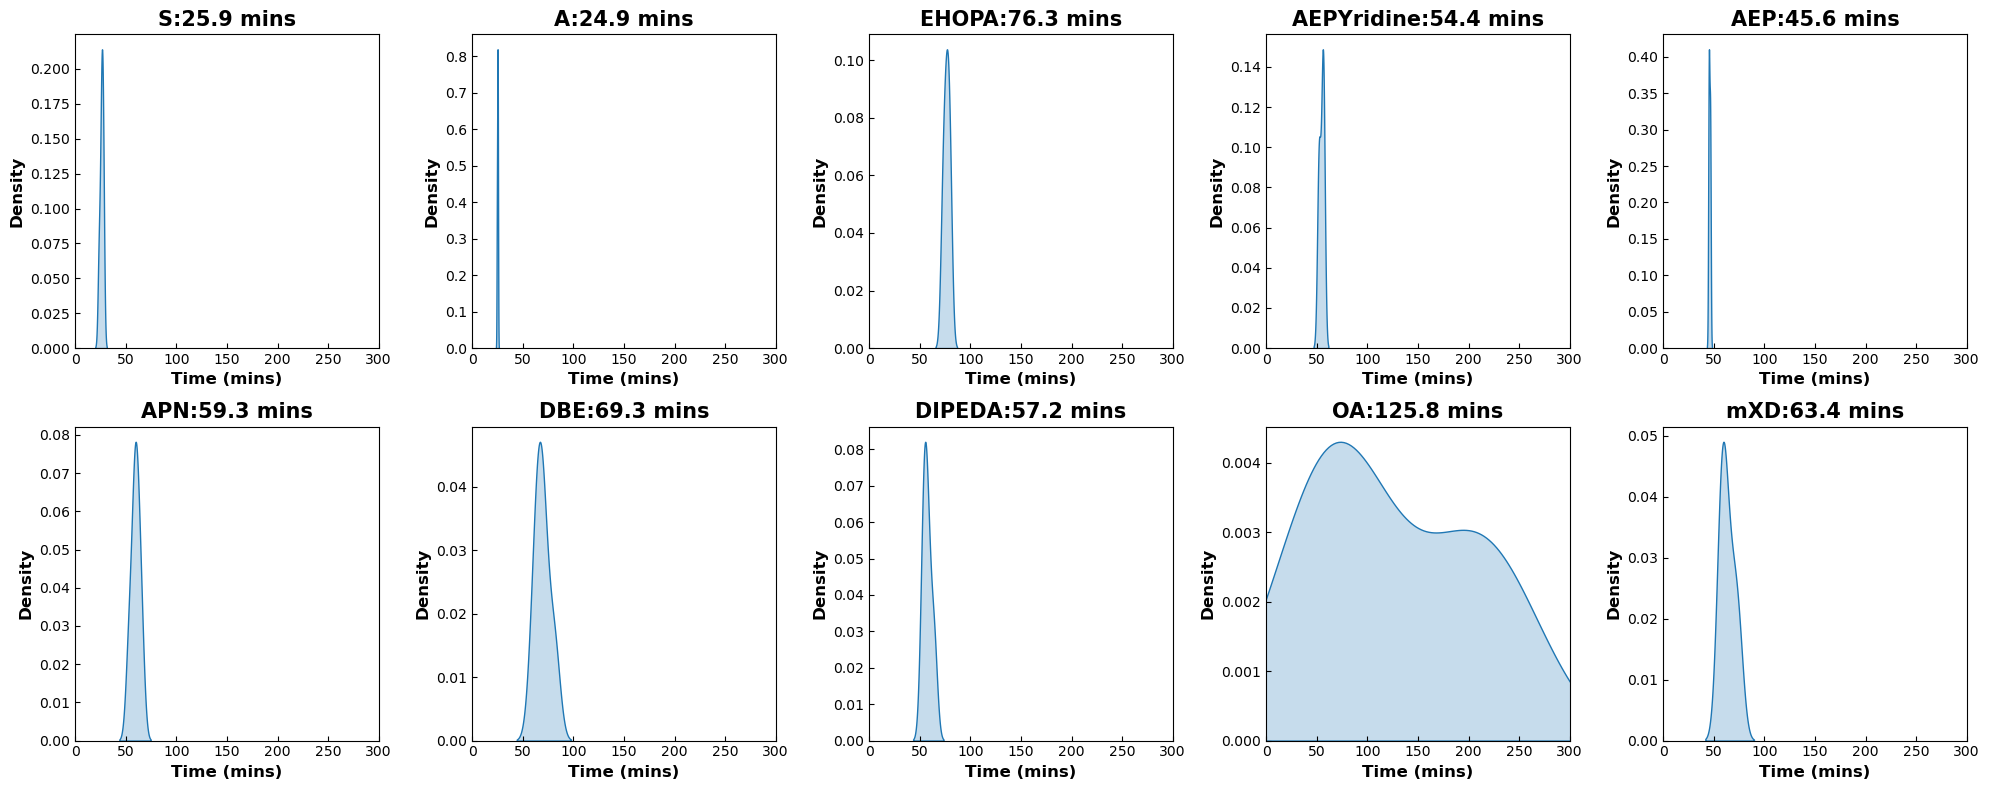

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# 示例形状和标签

for j, ax in enumerate(axes.ravel()):
    time = round(rdkit_T_df.mean()[j],1)
    if j < len(name_list):
        sns.kdeplot(rdkit_T_df.iloc[:,j], fill=True,ax=ax)
        # 添加图例
        # plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
        # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
        # 设置图形标题和坐标轴标签
        ax.set_title(f"{name_list[j]}:{time} mins",fontsize=15,fontweight='bold')
        ax.set_xlabel("Time (mins)",fontsize=12,fontweight='bold')     
        ax.tick_params(axis='both', direction='in', which='both')
        ax.set_xlim(0,300)
        ax.set_ylabel("Density",fontsize=12,fontweight='bold')
plt.tight_layout()
# 显示图形
plt.savefig('Time_Density.png',dpi=300)
plt.show()

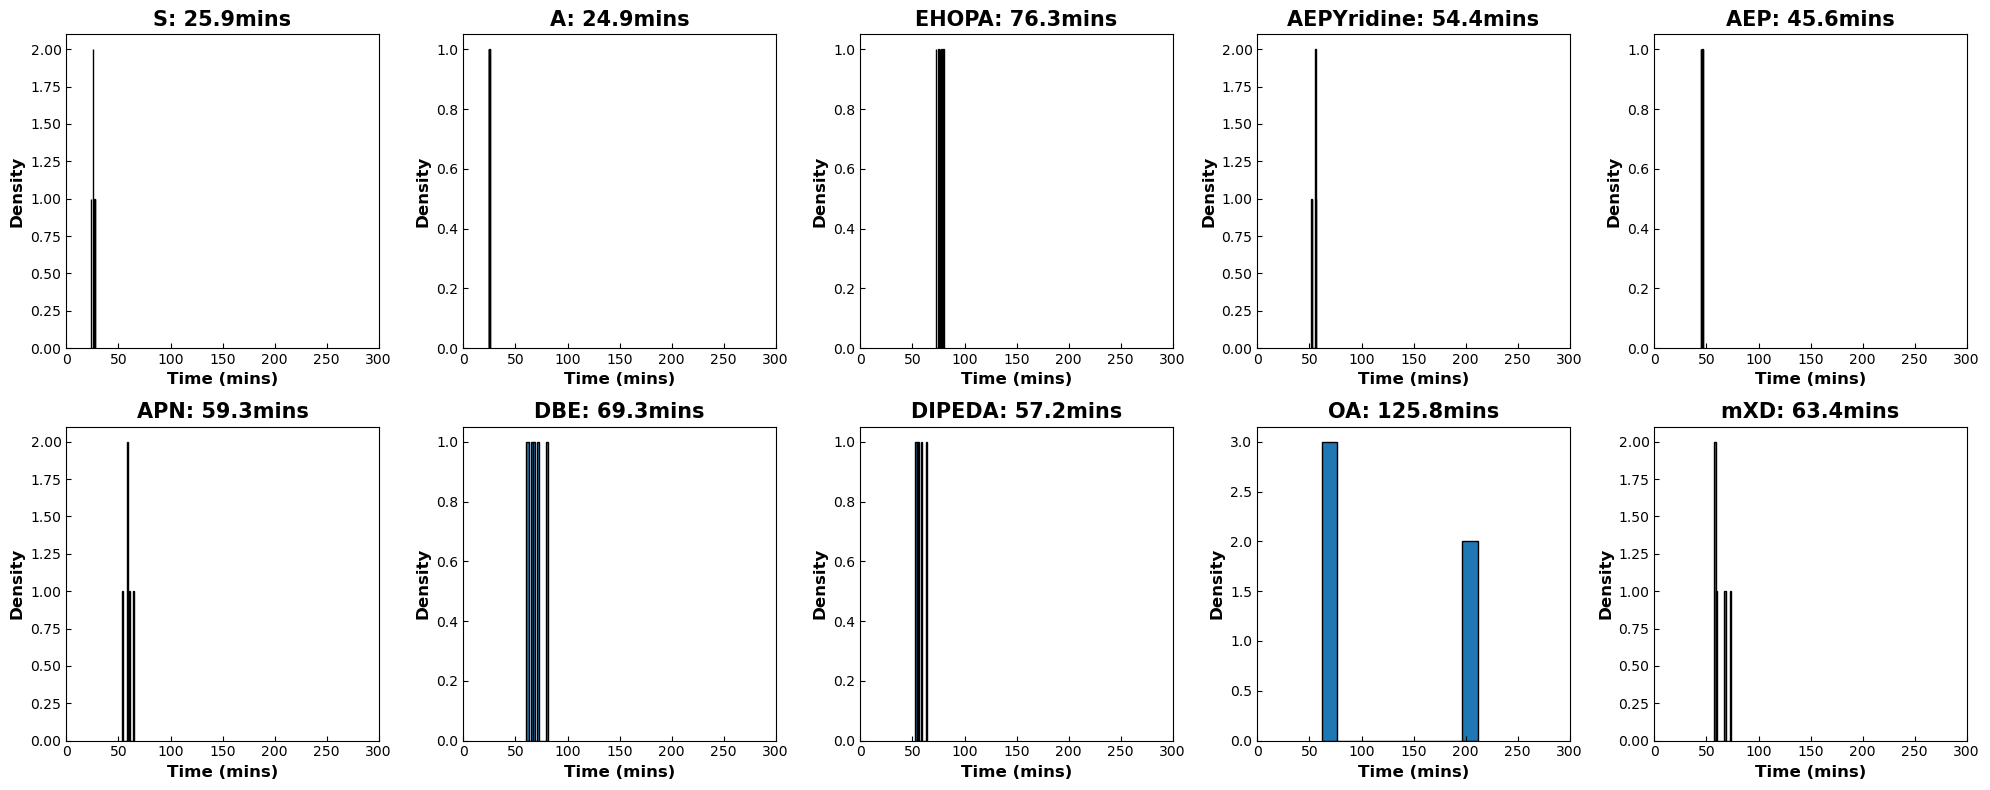

In [34]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# 示例形状和标签

for j, ax in enumerate(axes.ravel()):
    time = round(rdkit_T_df.mean()[j],1)
    if j < len(name_list):
        ax.hist(rdkit_T_df.iloc[:,j], bins=10, edgecolor='k')

        # 添加图例
        # plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), ncol=2, title="CYTOP")
        # plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), ncol=2, title="CYTOP")
        # 设置图形标题和坐标轴标签
        ax.set_title(f"{name_list[j]}: {time}mins",fontsize=15,fontweight='bold')
        ax.set_xlabel("Time (mins)",fontsize=12,fontweight='bold')     
        ax.tick_params(axis='both', direction='in', which='both')
        ax.set_xlim(0,300)
        ax.set_ylabel("Density",fontsize=12,fontweight='bold')
plt.tight_layout()
# 显示图形
plt.savefig('Time_hist.png',dpi=300)
plt.show()